# 29.2.1 **Capstone Project Step 7: Experiment With Various Models**
---
**Bruce Walker, UCSD MLE/AI Bootcamp**

In this notebook, I use the data file I prepared in assignment 20.6.3 to evaluate and tune various machine learning models to determine which I want to use moving forward in this Capstone project.

Original Dataset source: https://www.kaggle.com/datasets/agungpambudi/network-malware-detection-connection-analysis/data?select=CTU-IoT-Malware-Capture-1-1conn.log.labeled.csv

Data files used in this notebook: https://github.com/bdwalker1/UCSD_MLE_Bootcamp_Capstone/tree/master/data/MalwareDetectionInNetworkTrafficData/combined

## Imports and Helper Functions

In [1]:
import os
import pickle
import time
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import f1_score as sklf1
from sklearn.metrics import PrecisionRecallDisplay as PRDisp

notebook_random_state = 42

In [2]:
class SimpleTimer:
    
    def __init__(self):
        self.reset()
        # self.running = False
        # self.start = -1
        # self.end = -1
        # self.laptimes = []

    def __time_diff(self, s, e):
        return (e - s)

    def reset(self):
        self.__running = False
        self.__start = -1
        self.__end = -1
        self.__laptimes = []

    def start(self):
        if self.__running:
            raise Exception("Timer already running. Must stop before starting.")
        else:
            self.reset()
            self.__start = time.time()
            self.__running = True

    def stop(self, is_last_lap=True):
        if not self.__running:
            raise Exception("Timer not running. Must start before stopping.")
        else:
            if is_last_lap:
                _ = self.laptime()
            self.__end = time.time()
            self.__running = False
            return self.__time_diff(self.__start, self.__end)

    def elapsed(self):
        if self.__running:
            return self.__time_diff(self.__start, time.time())
        else:
            return self.__time_diff(self.__start, self.__end)

    def laptime(self):
        if not self.__running:
            raise Exception("Timer not running. Must start before getting lap times.")
        else:
            self.__laptimes.append(time.time())
            elapsed_time = 0
            if len(self.__laptimes) == 1:
                elapsed_time = self.__time_diff(self.__start, self.__laptimes[0])
            else:
                elapsed_time = self.__time_diff(self.__laptimes[-2], self.__laptimes[-1])
            return elapsed_time

    def show_laptimes(self):
        laptimes = self.__laptimes
        lap_count = len(laptimes)
        if lap_count > 0:
            for n in range(0,lap_count):
                span = 0
                if n == 0:
                    span = self.__time_diff(self.__start, laptimes[n])
                else:
                    span = self.__time_diff(laptimes[n-1], laptimes[n])
                print(f"Lap {n+1}: {self.sts(span)}")
            if not self.__running:
                if self.__time_diff(laptimes[-1], self.__end) > .0001:
                    span = self.__time_diff(laptimes[-1], self.__end)
                    print(f"After Last Lap: {self.sts(span)}")
            
    def sts(self, seconds): # Span to String
        
        # Extract days, hours, minutes, and seconds
        days, remainder = divmod(seconds, 86400)
        hours, remainder = divmod(remainder, 3600)
        minutes, seconds = divmod(remainder, 60)
    
        output = ""
        if days > 0:
            output += f"{int(days)}d "
        if (days > 0) or (hours > 0):
            output += f"{int(hours)}h "
        if (days > 0) or (hours > 0) or (minutes > 0):
            output += f"{int(minutes)}m "
        output += f"{seconds:.3f}s"
        return output.strip()


## Load the Cleaned Data From Saved Files

In [3]:
datapath="G:/My Drive/UCSD_MLE_Bootcamp_Capstone/data/MalwareDetectionInNetworkTrafficData/combined/"
input_filename_prefix = "CTU-IoT-Malware-Capture_"

if not(os.path.exists(datapath)):
    datapath="/Users/bdwalker1/Library/CloudStorage/GoogleDrive-maritz.bruce@gmail.com/My Drive/UCSD_MLE_Bootcamp_Capstone/data/MalwareDetectionInNetworkTrafficData/combined/"
    if not(os.path.exists(datapath)):
        print("Data path does not exist!")

dtypes_dict = {'ts': 'float64', 'uid': 'string', 'id.orig_h': 'string', 'id.orig_p': 'int32', \
               'id.resp_h': 'string', 'id.resp_p': 'int32', 'proto': 'string', 'service': 'string', \
               'duration': 'O', 'orig_bytes': 'O', 'resp_bytes': 'O', \
               'conn_state': 'string', 'local_orig': 'string', 'local_resp': 'string', \
               'missed_bytes': 'int32', 'history': 'string', \
               'orig_pkts': 'int32', 'orig_ip_bytes': 'int32', 'resp_pkts': 'int32', 'resp_ip_bytes': 'int32', \
               'tunnel_parents': 'string', 'label': 'string', 'detailed-label': 'string', \
               'filename': 'string', 'date_time': 'string'}

full_df = pd.DataFrame()
chucksize = 1000000
recs_loaded = 0
for fileitem in os.scandir(datapath):
    if fileitem.is_file():
        if (fileitem.name.startswith(input_filename_prefix) and fileitem.name.endswith(".csv")):
            filepath = fileitem.path
            filename = fileitem.name
            with pd.read_csv(filepath, sep="|",low_memory=False, dtype=dtypes_dict, parse_dates=['date_time'], chunksize=chucksize) as reader:
                for df in reader:
                    full_df = pd.concat([full_df, df])
                    recs_loaded += df.shape[0]
                    print(f"\r{recs_loaded:>10} records loaded",end='')

print(f"\r{recs_loaded:>10} total records.     \n")

  25000363 total records.     



In [5]:
display(full_df.shape)

(25000363, 25)

## Remove columns we won't be using

In [7]:
# Dropping detailed label as we are only going to predict malicious or not...
full_df.drop("detailed-label",axis=1,inplace=True)

In [8]:
# Dropping filename column as it won't be predictive
full_df.drop("filename", axis=1, inplace=True)

In [9]:
# Dropping IP columns as we want model to train on traffic patterns independant of originating or responding host...')
full_df.drop(['id.orig_h','id.resp_h'], axis=1, inplace=True)


In [10]:
# Dropping duration, missed_bytes, orig_bytes, and resp_bytes columns
# because they are not populated for a majority of the dataset...
full_df.drop(['duration','missed_bytes','orig_bytes','resp_bytes',], axis=1, inplace=True)


In [11]:
print('Dropping any columns with only one value...')
for col in full_df:
     if (full_df[col].unique().shape[0] == 1):
         full_df.drop([col], axis=1, inplace=True)
         print(f'\t{col} dropped.')


Dropping any columns with only one value...
	local_orig dropped.
	local_resp dropped.
	tunnel_parents dropped.


In [12]:
print('Dropping any columns with all unique values (except date_time)...')
for col in full_df:
    if (col != 'date_time'):
        if (full_df[col].unique().shape[0] == full_df[col].shape[0]):
            full_df.drop([col], axis=1, inplace=True)
            print(f'\t{col} dropped.')


Dropping any columns with all unique values (except date_time)...
	ts dropped.
	uid dropped.


## Transform some data

In [13]:
# Pull potentially useful info from date stamp
print('\tParsing date stamp...')
full_df["day_of_week"] = full_df["date_time"].dt.dayofweek
full_df["day_of_week"] = full_df["day_of_week"].astype(np.uint8)
full_df["day_of_month"] = full_df["date_time"].dt.day
full_df["day_of_month"] = full_df["day_of_month"].astype(np.uint8)
full_df["hour_of_day"] =  full_df["date_time"].dt.hour
full_df["hour_of_day"] =  full_df["hour_of_day"].astype(np.uint8)

# Drop the raw timestamp and date/time columns
full_df.drop("date_time",axis=1,inplace=True)

	Parsing date stamp...


In [14]:
print('Creating binary label target...')
full_df["target"] = full_df["label"].apply(lambda x : 0 if x=="Benign" else 1)
full_df.drop("label",axis=1,inplace=True)


Creating binary label target...


## Select a Random Subset for Experimentation

In [15]:
if (("working_df" in locals()) or ("working_df" in globals())):
    del working_df

working_df = full_df.sample(n=3000000, random_state=notebook_random_state)


In [16]:
display(working_df.shape)

(3000000, 14)

## Split data for training/validation/testing

In [17]:
X = working_df.drop('target',axis=1)
y = working_df[['target']]
display(X.head())
display(y.head())


,id.orig_p,id.resp_p,proto,service,conn_state,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,day_of_week,day_of_month,hour_of_day
2188913,51008,23,tcp,-,S0,S,1,60,0,0,4,21,21
1442047,45290,23,tcp,-,S0,S,1,60,0,0,4,21,7
913975,59196,23,tcp,-,S0,S,1,60,0,0,5,22,4
2032591,43714,23,tcp,-,S0,S,2,120,0,0,3,28,11
157384,9035,62336,tcp,-,OTH,C,0,0,0,0,4,20,15


,target
2188913,0
1442047,0
913975,0
2032591,1
157384,1


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=notebook_random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=notebook_random_state)
display(X_train.shape)
display(y_train.shape)
display(X_val.shape)
display(y_val.shape)
display(X_test.shape)
display(y_test.shape)


(2167500, 13)

(2167500, 1)

(382500, 13)

(382500, 1)

(450000, 13)

(450000, 1)

### Balance the Training Set

In [19]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=notebook_random_state)

X_newtrain, y_newtrain = rus.fit_resample(X_train, y_train)
display(X_newtrain.shape)
display(y_newtrain.shape)


(1522686, 13)

(1522686, 1)

In [21]:
# Once we're happy with balanced datasets, make them the training sets
X_train, y_train = X_newtrain, y_newtrain

## Preprocess the training data

95.0 quantile Cut-off: 360.0
4725 outliers eliminated.
Percent of records kept: 0.996896930818304


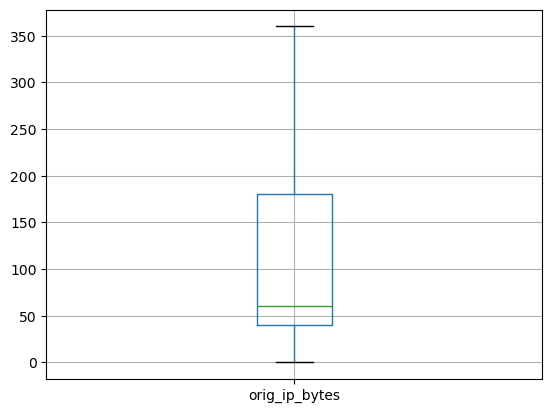

In [22]:
# Remove outliers based on orig_ip_bytes
pct = 0.95
cut_off = X_train['orig_ip_bytes'].quantile(pct)
print(f'{(pct*100):.1f} quantile Cut-off: {cut_off}')

orig_count = X_train.shape[0]
records_removed = sum(X_train['orig_ip_bytes'] > cut_off)
keeper_mask = X_train['orig_ip_bytes'] <= cut_off
y_train = y_train[keeper_mask]
X_train = X_train[keeper_mask]
print(f"{records_removed} outliers eliminated.")
pct_kept = X_train.shape[0] / orig_count
print(f'Percent of records kept: {pct_kept}')

del orig_count, records_removed, keeper_mask, pct_kept

X_train[['orig_ip_bytes']].boxplot()
plt.show()

In [23]:
print('Limiting number of distinct history values before encoding')
counts = X_train['history'].value_counts()
mask = X_train['history'].isin(counts[counts < 100].index)
X_train.loc[mask, 'history'] = 'Other'
X_train['history'].value_counts()

Limiting number of distinct history values before encoding


history
S        1208756
C         168942
I          99258
D          35771
-           2280
Dd          1404
Sr          1080
Other        284
^c           186
Name: count, dtype: Int64

In [24]:
display(X_train.shape)
display(y_train.shape)
display(X_val.shape)
display(y_val.shape)
display(X_test.shape)
display(y_test.shape)


(1517961, 13)

(1517961, 1)

(382500, 13)

(382500, 1)

(450000, 13)

(450000, 1)

In [25]:

print('\tEncoding protocol values...')
proto_encoder = OneHotEncoder(sparse_output=False, dtype=np.uint8, handle_unknown='ignore').set_output(transform="pandas")
proto_df = proto_encoder.fit_transform(X_train[["proto"]])
X_train = pd.concat([X_train, proto_df], axis=1)
X_train.drop('proto', axis=1, inplace=True)
del proto_df

print('\tEncoding service values...')
service_encoder = OneHotEncoder(sparse_output=False, dtype=np.uint8, handle_unknown='ignore').set_output(transform="pandas")
service_df = service_encoder.fit_transform(X_train[["service"]])
X_train = pd.concat([X_train, service_df], axis=1)
X_train.drop('service', axis=1, inplace=True)
del service_df

print('\tEncoding connection state values...')
conn_state_encoder = OneHotEncoder(sparse_output=False, dtype=np.uint8, handle_unknown='ignore').set_output(transform="pandas")
conn_state_df = conn_state_encoder.fit_transform(X_train[["conn_state"]])
X_train = pd.concat([X_train, conn_state_df], axis=1)
X_train.drop('conn_state', axis=1, inplace=True)
del conn_state_df

print('\tEncoding history values...')
history_encoder = OneHotEncoder(sparse_output=False, dtype=np.uint8, handle_unknown='ignore').set_output(transform="pandas")
history_df = history_encoder.fit_transform(X_train[["history"]])
X_train = pd.concat([X_train, history_df], axis=1)
X_train.drop('history', axis=1, inplace=True)
del history_df



	Encoding protocol values...
	Encoding service values...
	Encoding connection state values...
	Encoding history values...


In [26]:
# Scale some numerical columns
def minmax_scale_column( df, col_name ):
    mm_scaler = MinMaxScaler()
    df[col_name] = mm_scaler.fit_transform(df[[col_name]])
    return mm_scaler

orig_ip_bytes_scaler = minmax_scale_column( X_train, 'orig_ip_bytes' )
orig_pkts_scaler = minmax_scale_column( X_train, 'orig_pkts' )
resp_ip_bytes_scaler = minmax_scale_column( X_train, 'resp_ip_bytes' )
resp_pkts_scaler = minmax_scale_column( X_train, 'resp_pkts' )


## Now pre-process validation and test data

In [27]:
def preprocess(df, silent=False):
    if (not silent):
        print('\tEncoding protocol values...')
    proto_df = proto_encoder.transform(df[["proto"]])
    df = pd.concat([df, proto_df], axis=1)
    df.drop('proto', axis=1, inplace=True)
    del proto_df
    
    if (not silent):
        print('\tEncoding service values...')
    service_df = service_encoder.transform(df[["service"]])
    df = pd.concat([df, service_df], axis=1)
    df.drop('service', axis=1, inplace=True)
    del service_df
    
    if (not silent):
        print('\tEncoding connection state values...')
    conn_state_df = conn_state_encoder.transform(df[["conn_state"]])
    df = pd.concat([df, conn_state_df], axis=1)
    df.drop('conn_state', axis=1, inplace=True)
    del conn_state_df

    if (not silent):
        print('\tEncoding history values...')
    history_df = history_encoder.transform(df[["history"]])
    df = pd.concat([df, history_df], axis=1)
    df.drop('history', axis=1, inplace=True)
    del history_df

    def apply_scaler( scaler, df, col_name ):
        df[col_name] = scaler.transform(df[[col_name]])
        return df

    if (not silent):
        print(f"\tApplying scalers to numeric columns...")
    df = apply_scaler( orig_ip_bytes_scaler, df, 'orig_ip_bytes' )
    df = apply_scaler( orig_pkts_scaler, df, 'orig_pkts' )
    df = apply_scaler( resp_ip_bytes_scaler, df, 'resp_ip_bytes' )
    df = apply_scaler( resp_pkts_scaler, df, 'resp_pkts' )

    if (not silent):
        print(f"Preprocessing done.\n")

    return df


In [28]:
print("Preprocessing X_val...")
X_val = preprocess(X_val)

print("Preprocessing X_test...")
X_test = preprocess(X_test)


Preprocessing X_val...
	Encoding protocol values...
	Encoding service values...
	Encoding connection state values...
	Encoding history values...
	Applying scalers to numeric columns...
Preprocessing done.

Preprocessing X_test...
	Encoding protocol values...
	Encoding service values...
	Encoding connection state values...
	Encoding history values...
	Applying scalers to numeric columns...
Preprocessing done.



In [29]:
display(X_train.shape)
display(y_train.shape)
display(X_val.shape)
display(y_val.shape)
display(X_test.shape)
display(y_test.shape)


(1517961, 35)

(1517961, 1)

(382500, 35)

(382500, 1)

(450000, 35)

(450000, 1)

In [30]:
display(X_train.agg(['min', 'max', 'mean']))
display(X_val.agg(['min', 'max', 'mean']))
display(X_test.agg(['min', 'max', 'mean']))


,id.orig_p,id.resp_p,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,day_of_week,day_of_month,hour_of_day,proto_icmp,...,conn_state_SH,history_-,history_C,history_D,history_Dd,history_I,history_Other,history_S,history_Sr,history_^c
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,65535.000000,65533.000000,1.000000,1.000000,1.000000,1.000000,6.000000,28.000000,23.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
mean,41443.671762,7895.798258,0.204277,0.282372,0.000304,0.000113,3.699109,22.156277,12.426036,0.001502,...,0.000005,0.001502,0.111295,0.023565,0.000925,0.065389,0.000187,0.796302,0.000711,0.000123


,id.orig_p,id.resp_p,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,day_of_week,day_of_month,hour_of_day,proto_icmp,...,conn_state_SH,history_-,history_C,history_D,history_Dd,history_I,history_Other,history_S,history_Sr,history_^c
min,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.0,0.000000,0.000000,0.000000
max,65535.000000,65535.000000,567.777778,567.777778,7.7500,3.337324,6.000000,28.000000,23.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.00000,1.00000,0.0,1.000000,1.000000,1.000000
mean,39866.671877,9674.484107,0.220993,0.296193,0.0015,0.000848,3.532322,22.586157,12.696358,0.000905,...,0.000005,0.000905,0.142954,0.017009,0.00068,0.08538,0.0,0.749022,0.000648,0.000071


,id.orig_p,id.resp_p,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,day_of_week,day_of_month,hour_of_day,proto_icmp,...,conn_state_SH,history_-,history_C,history_D,history_Dd,history_I,history_Other,history_S,history_Sr,history_^c
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000
max,65535.000000,65519.000000,15.111111,23.827778,16.750000,136.102817,6.000000,28.000000,23.000000,1.000000,...,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.00000,1.000000,1.000000
mean,39930.341869,9658.307767,0.221083,0.296930,0.001839,0.001727,3.533927,22.580078,12.683389,0.001027,...,0.0,0.001027,0.142593,0.017349,0.000671,0.085084,0.0,0.74888,0.000667,0.000098


## Let's train some models

### Set up some functions for our training and testing

In [31]:
def train_model( model_name, model, X, y):
    tmr = SimpleTimer()
    print(f"Training {model_name} model...")
    tmr.start()
    model.fit(X, y["target"])
    train_time = tmr.stop()
    print(f"\tTraining time: {train_time:.4}s")

def test_model( model_name, test_name, model, X, y):
    tmr = SimpleTimer()
    print(f"\nEvaluating {model_name} Performance - {test_name}:")
    tmr.start()
    y_pred = model.predict(X)
    print(f"\tExecution time: {tmr.stop():.4}s")
    # If predictions aren't binary, convert to binary
    if (len(list(y_pred)) > 2):
        y_pred = (y_pred >= 0.5)
    accuracy = accuracy_score(y, y_pred)
    rpt = classification_report(y, y_pred)
    print(f"{model_name} Performance - {test_name}:")
    print(f"\t Accuracy: {accuracy:.4%}")
    print(f"\t Report:\n{rpt}")
    plt.clf()
    pr_plot = PRDisp.from_predictions( y, y_pred, name=model_name, plot_chance_level=True)
    _ = pr_plot.ax_.set_title("2-class Precision-Recall curve")
    plt.show()


### First, try random forest

In [32]:
from sklearn.ensemble import RandomForestClassifier

model_name = "Random Forest"

rf_model = RandomForestClassifier(n_estimators=100, random_state=notebook_random_state)

train_model(model_name, rf_model, X_train, y_train)


Training Random Forest model...
	Training time: 56.16s



Evaluating Random Forest Performance - train:
	Execution time: 5.323s
Random Forest Performance - train:
	 Accuracy: 100.0000%
	 Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    760386
           1       1.00      1.00      1.00    757575

    accuracy                           1.00   1517961
   macro avg       1.00      1.00      1.00   1517961
weighted avg       1.00      1.00      1.00   1517961



<Figure size 640x480 with 0 Axes>

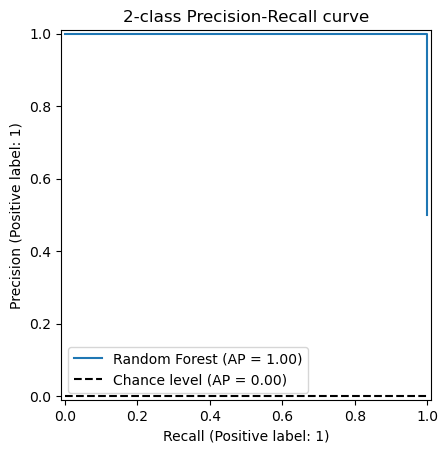


Evaluating Random Forest Performance - validation:
	Execution time: 1.542s
Random Forest Performance - validation:
	 Accuracy: 99.7325%
	 Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    134239
           1       1.00      1.00      1.00    248261

    accuracy                           1.00    382500
   macro avg       1.00      1.00      1.00    382500
weighted avg       1.00      1.00      1.00    382500



<Figure size 640x480 with 0 Axes>

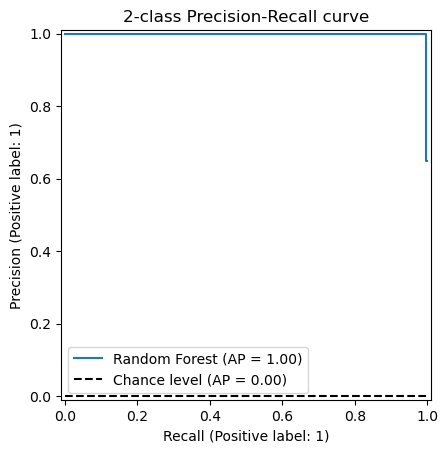


Evaluating Random Forest Performance - test:
	Execution time: 1.732s
Random Forest Performance - test:
	 Accuracy: 99.7124%
	 Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    158103
           1       1.00      1.00      1.00    291897

    accuracy                           1.00    450000
   macro avg       1.00      1.00      1.00    450000
weighted avg       1.00      1.00      1.00    450000



<Figure size 640x480 with 0 Axes>

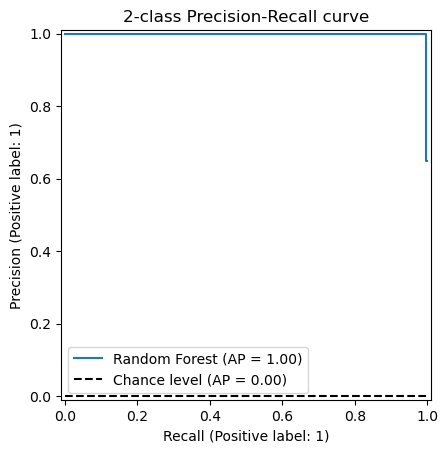

In [37]:
model_name = "Random Forest"

test_model(model_name, "train", rf_model, X_train, y_train)
test_model(model_name, "validation", rf_model, X_val, y_val)
test_model(model_name, "test", rf_model, X_test, y_test)


---

**Thoughts on Random Forest Model**

Random Forest has good scores and fairly fast training and prediction times. This is a good candidate for this project. 

---

### Now, let's try SVC

**Note:** The cells for SVC model training and evaluation are commented out so as not to waste time when re-running this notebook.

The evaluation results from my SVC run are in a Markdown cell below.


In [33]:
# from sklearn.svm import SVC

# model_name = "SVC"

# svc_model = SVC(gamma='scale', max_iter=500, random_state=notebook_random_state)

# train_model(model_name, svc_model, X_train, y_train)


In [34]:
# model_name = "SVC"

# test_model(model_name, "train", svc_model, X_train, y_train)
# test_model(model_name, "validation", svc_model, X_val, y_val)
# test_model(model_name, "test", svc_model, X_test, y_test)


---
### Evaluation Data from the SVC model

```
Evaluating SVC Performance - train:
	Execution time: 277.0s
SVC Performance - train:
	 Accuracy: 37.0243%
	 Report:
              precision    recall  f1-score   support

           0       0.04      0.04      0.04    736290
           1       0.51      0.55      0.53   1355910

    accuracy                           0.37   2092200
   macro avg       0.28      0.29      0.28   2092200
weighted avg       0.35      0.37      0.36   2092200


Evaluating SVC Performance - validation:
	Execution time: 39.54s
SVC Performance - validation:
	 Accuracy: 37.1327%
	 Report:
              precision    recall  f1-score   support

           0       0.04      0.04      0.04    105561
           1       0.51      0.55      0.53    194439

    accuracy                           0.37    300000
   macro avg       0.28      0.30      0.29    300000
weighted avg       0.35      0.37      0.36    300000


Evaluating SVC Performance - test:
	Execution time: 78.65s
SVC Performance - test:
	 Accuracy: 37.0450%
	 Report:
              precision    recall  f1-score   support

           0       0.04      0.04      0.04    210793
           1       0.51      0.55      0.53    389207

    accuracy                           0.37    600000
   macro avg       0.28      0.29      0.29    600000
weighted avg       0.35      0.37      0.36    600000
```
---

---

**Thoughts on SVC Model**

SVC seems to be very slow with very poor scores for this task. Time to move on to other models.

---

### Let's try Linear Regression

In [35]:
from sklearn.linear_model import LinearRegression

model_name = "Linear Regression"

lr_model = LinearRegression()

train_model(model_name, lr_model, X_train, y_train)


Training Linear Regression model...
	Training time: 1.123s



Evaluating Linear Regression Performance - train:
	Execution time: 0.235s
Linear Regression Performance - train:
	 Accuracy: 97.4596%
	 Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98    760386
           1       0.99      0.96      0.97    757575

    accuracy                           0.97   1517961
   macro avg       0.98      0.97      0.97   1517961
weighted avg       0.98      0.97      0.97   1517961



<Figure size 640x480 with 0 Axes>

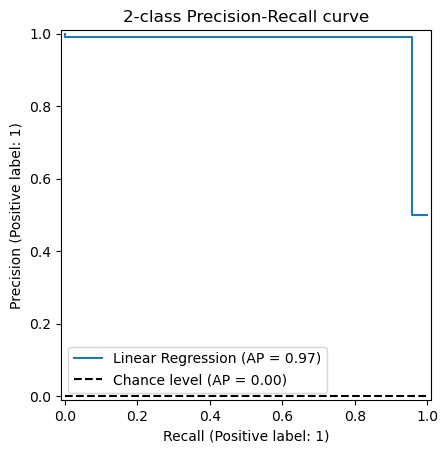


Evaluating Linear Regression Performance - validation:
	Execution time: 0.04301s
Linear Regression Performance - validation:
	 Accuracy: 96.9286%
	 Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96    134239
           1       1.00      0.96      0.98    248261

    accuracy                           0.97    382500
   macro avg       0.96      0.97      0.97    382500
weighted avg       0.97      0.97      0.97    382500



<Figure size 640x480 with 0 Axes>

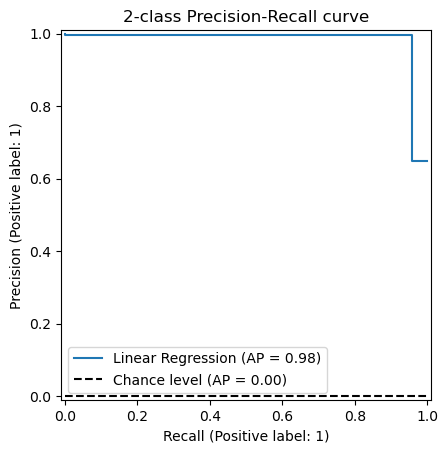


Evaluating Linear Regression Performance - test:
	Execution time: 0.047s
Linear Regression Performance - test:
	 Accuracy: 96.8853%
	 Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96    158103
           1       1.00      0.96      0.98    291897

    accuracy                           0.97    450000
   macro avg       0.96      0.97      0.97    450000
weighted avg       0.97      0.97      0.97    450000



<Figure size 640x480 with 0 Axes>

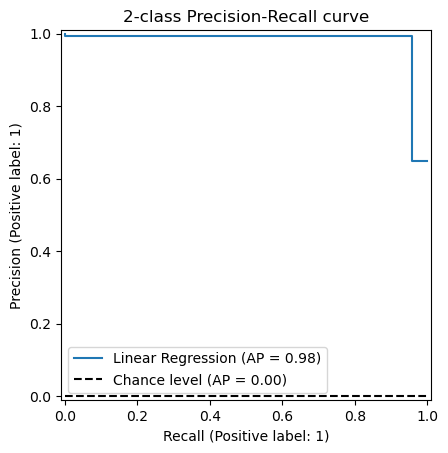

In [36]:
model_name = "Linear Regression"

test_model(model_name, "train", lr_model, X_train, y_train)
test_model(model_name, "validation", lr_model, X_val, y_val)
test_model(model_name, "test", lr_model, X_test, y_test)


---

**Thoughts on Linear Regression Model**

Linear Regression is super fast to train and execute, but even though it has ~97% accuracy I think the task at hand needs higher accuracy and better precision scores.

---

### Let's try AdaBoost

In [38]:
from sklearn.ensemble import AdaBoostClassifier

model_name = "AdaBoost"

ada_model = AdaBoostClassifier(n_estimators=100, algorithm='SAMME', random_state=notebook_random_state)

train_model(model_name, ada_model, X_train, y_train)


Training AdaBoost model...
	Training time: 75.8s



Evaluating AdaBoost Performance - train:
	Execution time: 13.23s
AdaBoost Performance - train:
	 Accuracy: 99.6780%
	 Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    760386
           1       0.99      1.00      1.00    757575

    accuracy                           1.00   1517961
   macro avg       1.00      1.00      1.00   1517961
weighted avg       1.00      1.00      1.00   1517961



<Figure size 640x480 with 0 Axes>

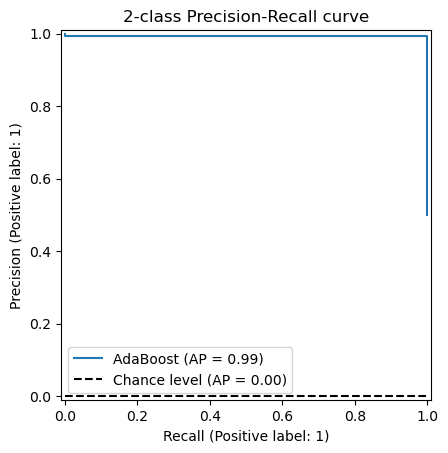


Evaluating AdaBoost Performance - validation:
	Execution time: 3.718s
AdaBoost Performance - validation:
	 Accuracy: 99.4944%
	 Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    134239
           1       1.00      1.00      1.00    248261

    accuracy                           0.99    382500
   macro avg       0.99      0.99      0.99    382500
weighted avg       0.99      0.99      0.99    382500



<Figure size 640x480 with 0 Axes>

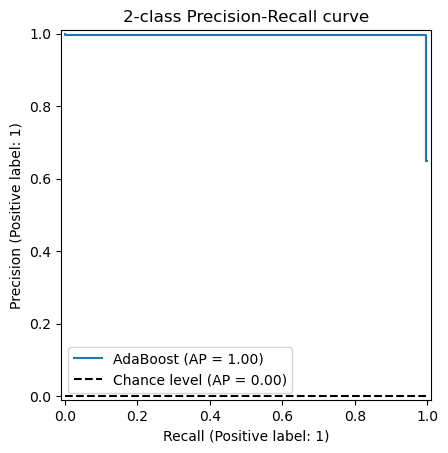


Evaluating AdaBoost Performance - test:
	Execution time: 4.217s
AdaBoost Performance - test:
	 Accuracy: 99.4584%
	 Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    158103
           1       1.00      1.00      1.00    291897

    accuracy                           0.99    450000
   macro avg       0.99      0.99      0.99    450000
weighted avg       0.99      0.99      0.99    450000



<Figure size 640x480 with 0 Axes>

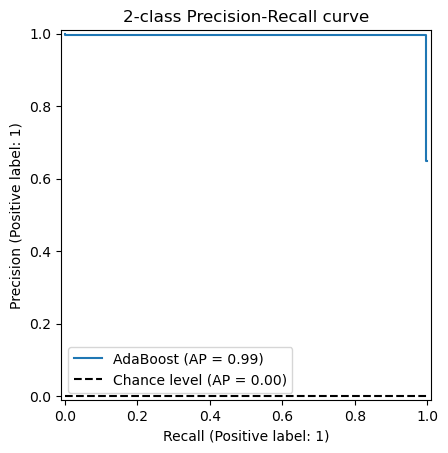

In [39]:
model_name = "AdaBoost"

test_model(model_name, "train", ada_model, X_train, y_train)
test_model(model_name, "validation", ada_model, X_val, y_val)
test_model(model_name, "test", ada_model, X_test, y_test)


---

**Thoughts on AdaBoost Model**

AdaBoost has similar training and prediction times to Random Forest, but initial scores are not quite as high. Still, it may be worth trying some hypertuning to compare against Random Forest for final model selection.

---

### Let's try Gradient Boosting

In [40]:
from sklearn.ensemble import GradientBoostingClassifier

model_name = "Gradient Boosting"

gb_model = GradientBoostingClassifier(n_estimators=100, random_state=notebook_random_state)

train_model(model_name, gb_model, X_train, y_train)


Training Gradient Boosting model...
	Training time: 138.8s



Evaluating Gradient Boosting Performance - train:
	Execution time: 1.954s
Gradient Boosting Performance - train:
	 Accuracy: 99.9296%
	 Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    760386
           1       1.00      1.00      1.00    757575

    accuracy                           1.00   1517961
   macro avg       1.00      1.00      1.00   1517961
weighted avg       1.00      1.00      1.00   1517961



<Figure size 640x480 with 0 Axes>

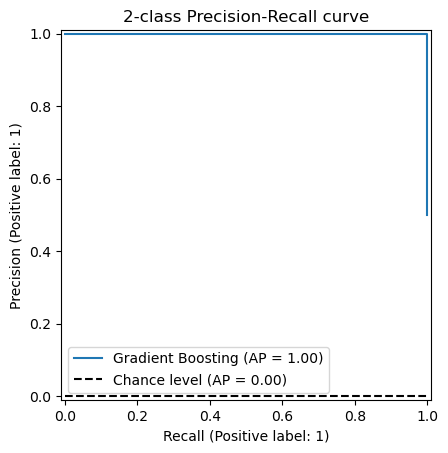


Evaluating Gradient Boosting Performance - validation:
	Execution time: 0.628s
Gradient Boosting Performance - validation:
	 Accuracy: 99.9380%
	 Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    134239
           1       1.00      1.00      1.00    248261

    accuracy                           1.00    382500
   macro avg       1.00      1.00      1.00    382500
weighted avg       1.00      1.00      1.00    382500



<Figure size 640x480 with 0 Axes>

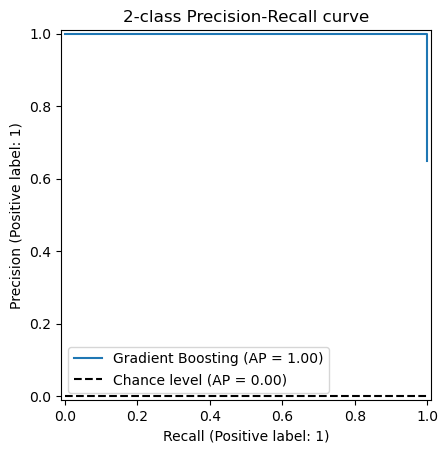


Evaluating Gradient Boosting Performance - test:
	Execution time: 0.721s
Gradient Boosting Performance - test:
	 Accuracy: 99.9349%
	 Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    158103
           1       1.00      1.00      1.00    291897

    accuracy                           1.00    450000
   macro avg       1.00      1.00      1.00    450000
weighted avg       1.00      1.00      1.00    450000



<Figure size 640x480 with 0 Axes>

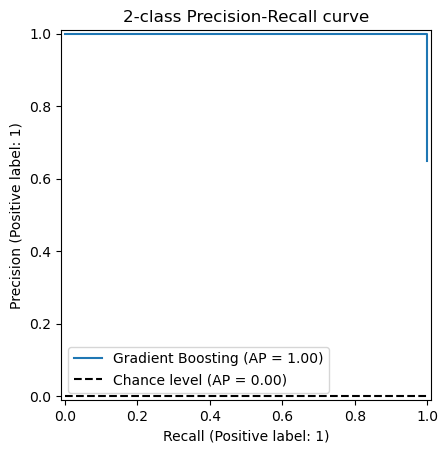

In [41]:
model_name = "Gradient Boosting"

test_model(model_name, "train", gb_model, X_train, y_train)
test_model(model_name, "validation", gb_model, X_val, y_val)
test_model(model_name, "test", gb_model, X_test, y_test)


---

**Thoughts on Gradient Boosting Model**

We have a new winner! Gradient Boosting has longer training time to Random Forest or AdaBoost, but faster execution times for predictions. Initial performance scores are higher -- this is definitely worth trying out in the hyper-tuning phase.

---

## Let's try some Hyper-Tuning

In [43]:
eval_column_list = ['name', 'param_val', 'accuracy', 'stddev', 'time', 'size', 'scores']

def modelsize( model ):
    pickle.dump(model, open('model.pkl', 'wb'))
    file_size = os.path.getsize('model.pkl')
    os.remove('model.pkl')
    return file_size
    
def kfold_eval( model_name, param_val, model, X, y):
    tmr = SimpleTimer()
    tmr.start()
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=notebook_random_state)
    n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=6, error_score='raise')
    eval_time = tmr.stop()
    eval_score = pd.DataFrame([[model_name, 
                                param_val,
                                np.mean(n_scores), 
                                np.std(n_scores), 
                                eval_time, 
                                modelsize(model), 
                                list(n_scores)]], columns=eval_column_list)
    print(f" {eval_time: .4f}s")
    return eval_score

def evaluate_models(models, X, y):
    results = pd.DataFrame(columns=eval_column_list)
    for name, param_val, model in models:
        print(f"Evaluating {name}...", end='')
        eval_df = kfold_eval( name, param_val, model, X, y)
        if (results.shape[0] == 0):
            results = eval_df
        else:
            results = pd.concat([results, eval_df])
    return results

def make_nestimator_models(model_name, classifier):
    models = list()
    # n_ests = [10, 50, 100, 200, 500]
    n_ests = [ 8, 9, 10, 11, 12, 15, 20]
    for n in n_ests:
        this_model = f"{model_name} - {n} estimators"
        models.append((this_model, n, classifier(n_estimators=n, algorithm='SAMME', random_state=notebook_random_state)))
    return models


### AdaBoost

**Note:** Because you can't directly change max_depth for AdaBoost, we're going to try some "manual" grid 
searching before moving on to automated hyper-tuning for AdaBoost

In [44]:
all_results = pd.DataFrame(columns=eval_column_list)

all_results = evaluate_models(make_nestimator_models("AdaBoost", AdaBoostClassifier), X_val, y_val)
display(all_results)

Evaluating AdaBoost - 8 estimators...  18.1298s
Evaluating AdaBoost - 9 estimators...  18.7984s
Evaluating AdaBoost - 10 estimators...  20.5207s
Evaluating AdaBoost - 11 estimators...  23.0426s
Evaluating AdaBoost - 12 estimators...  25.0320s
Evaluating AdaBoost - 15 estimators...  30.5591s
Evaluating AdaBoost - 20 estimators...  38.5941s


,name,param_val,accuracy,stddev,time,size,scores
0,AdaBoost - 8 estimators,8,0.980904,0.001066,18.129755,218,"[0.9791895424836601, 0.9818300653594771, 0.980..."
0,AdaBoost - 9 estimators,9,0.976826,0.000692,18.798426,218,"[0.9764705882352941, 0.9773856209150327, 0.976..."
0,AdaBoost - 10 estimators,10,0.972858,0.000786,20.520713,218,"[0.9727843137254902, 0.9736209150326798, 0.973..."
0,AdaBoost - 11 estimators,11,0.983009,0.000551,23.042578,218,"[0.9831372549019608, 0.9836339869281046, 0.982..."
0,AdaBoost - 12 estimators,12,0.982797,0.000553,25.031960,218,"[0.9828496732026144, 0.9834509803921568, 0.982..."
0,AdaBoost - 15 estimators,15,0.982038,0.001434,30.559080,218,"[0.9828496732026144, 0.9833725490196078, 0.982..."
0,AdaBoost - 20 estimators,20,0.982813,0.000602,38.594140,218,"[0.9828496732026144, 0.9836078431372549, 0.982..."


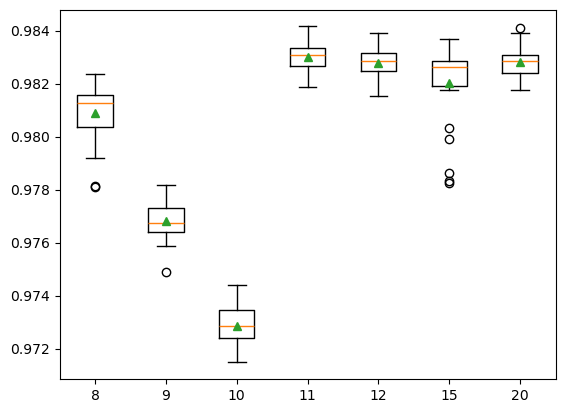

In [45]:
plt.boxplot(all_results["scores"], labels=all_results["param_val"], showmeans=True)
plt.show()

In [46]:
def make_maxdepth_models(model_name, classifier, depth_classifier):
    models = list()
    for i in range(2,7):
        base = depth_classifier(max_depth=i)
        this_model = f"{model_name} - max_depth = {i}"
        models.append((this_model, i, classifier(n_estimators=11, estimator=base, algorithm='SAMME', random_state=notebook_random_state)))
    return models


In [47]:
maxd_results = pd.DataFrame(columns=eval_column_list)

maxd_results = evaluate_models(make_maxdepth_models("AdaBoost", AdaBoostClassifier, DecisionTreeClassifier), X_val, y_val)
display(maxd_results)

Evaluating AdaBoost - max_depth = 2...  30.9880s
Evaluating AdaBoost - max_depth = 3...  39.4634s
Evaluating AdaBoost - max_depth = 4...  46.7522s
Evaluating AdaBoost - max_depth = 5...  53.2161s
Evaluating AdaBoost - max_depth = 6...  59.7994s


,name,param_val,accuracy,stddev,time,size,scores
0,AdaBoost - max_depth = 2,2,0.996726,0.001264,30.988000,534,"[0.9966535947712418, 0.998640522875817, 0.9965..."
0,AdaBoost - max_depth = 3,3,0.999685,0.000196,39.463353,534,"[0.9995032679738562, 0.9996078431372549, 0.999..."
0,AdaBoost - max_depth = 4,4,0.999928,0.000046,46.752206,534,"[0.9999477124183006, 0.9999738562091504, 0.999..."
0,AdaBoost - max_depth = 5,5,0.999967,0.000030,53.216084,534,"[0.9999477124183006, 1.0, 0.9999738562091504, ..."
0,AdaBoost - max_depth = 6,6,0.999959,0.000028,59.799441,534,"[0.9999477124183006, 0.9999477124183006, 0.999..."


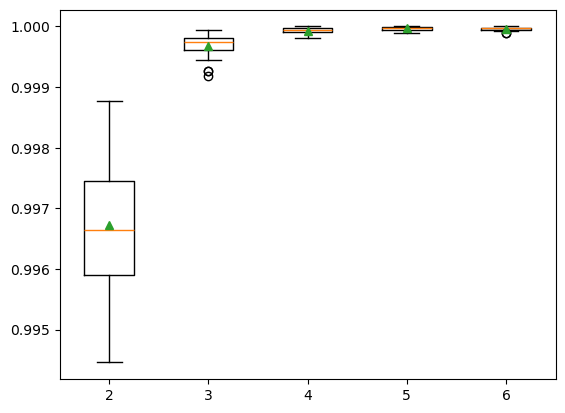

In [48]:
plt.boxplot(maxd_results["scores"], labels=maxd_results["param_val"], showmeans=True)
plt.show()

### Now that we have a good idea where we should be, let's try a randomized search with the larger dataset

We'll create a scoring function that uses F1 score while penalizing for extra time.

In [49]:
def f1SpeedScore(predictor, X, y):
    tmr = SimpleTimer()
    tmr.start()
    y_pred = predictor.predict(X)
    pred_time = tmr.stop()
    n = len(y)
    ns_per_rec = pred_time * 1000000 / n
    
    time_penalty = (ns_per_rec) * 0.001 # 0.001 score penality per nanosecond
    f1 = sklf1(y, y_pred)
    
    score = f1 - time_penalty
    
    return score


In [51]:
ada_timer = SimpleTimer()
ada_base_classifier = DecisionTreeClassifier(max_depth=5)
ada_model = AdaBoostClassifier(estimator=ada_base_classifier, algorithm='SAMME')
ada_param_grid = {
    # 'n_estimators': [10, 25, 50, 100, 150, 200, 250, 300],
    'n_estimators': [10, 11, 12, 13, 14, 15],
    # 'learning_rate': [ 0 + (n*0.2) for n in range(1,11)],
    'learning_rate': [ 0 + (n*0.1) for n in range(1,11)],
}

ada_random_search = RandomizedSearchCV(
    ada_model,
    ada_param_grid,
    scoring=f1SpeedScore,
    n_jobs=7,
    cv=5,
    n_iter=10,
    verbose=10,
    random_state=notebook_random_state
)

print(f"Started at {time.ctime()}")
ada_timer.start()
ada_random_search.fit(X_train, y_train["target"])
print(f"Time for random search: {ada_timer.sts(ada_timer.stop())}")
print(f"Finished at {time.ctime()}")


Started at Mon Feb 24 12:07:16 2025
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Time for random search: 7m 10.158s
Finished at Mon Feb 24 12:14:26 2025


In [52]:
display(ada_random_search.best_params_)
display(ada_random_search.best_score_)

{'n_estimators': 13, 'learning_rate': 1.0}

0.9981125339638194

In [53]:

display(pd.DataFrame(ada_random_search.cv_results_)[["mean_fit_time","mean_score_time","mean_test_score"]].sort_values(by="mean_test_score",ascending=False))

,mean_fit_time,mean_score_time,mean_test_score
9,52.940639,0.646612,0.998113
8,43.249910,0.852266,0.997473
7,52.156158,0.895854,0.997447
5,51.823391,0.930210,0.997356
2,47.193775,0.938805,0.997277
4,46.683867,0.939207,0.997170
3,66.207295,0.995204,0.997095
6,60.364929,1.154789,0.996572
0,43.335287,1.023202,0.995841
1,64.018690,1.354005,0.995473


In [54]:
display(pd.DataFrame(ada_random_search.cv_results_)
        [["mean_test_score","std_test_score","param_n_estimators","param_learning_rate"]].sort_values(by="mean_test_score",ascending=False).head(10))

,mean_test_score,std_test_score,param_n_estimators,param_learning_rate
9,0.998113,0.000441,13,1.0
8,0.997473,0.000183,10,0.3
7,0.997447,0.000131,10,0.9
5,0.997356,0.000117,10,1.0
2,0.997277,0.000159,10,0.7
4,0.997170,0.000173,11,0.3
3,0.997095,0.000434,13,0.8
6,0.996572,0.000459,13,0.6
0,0.995841,0.000162,10,0.1
1,0.995473,0.000332,15,0.1


In [55]:
best_ada_model = ada_random_search.best_estimator_


Evaluating AdaBoost Best Model Performance - train:
	Execution time: 2.079s
AdaBoost Best Model Performance - train:
	 Accuracy: 100.0000%
	 Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    760386
           1       1.00      1.00      1.00    757575

    accuracy                           1.00   1517961
   macro avg       1.00      1.00      1.00   1517961
weighted avg       1.00      1.00      1.00   1517961



<Figure size 640x480 with 0 Axes>

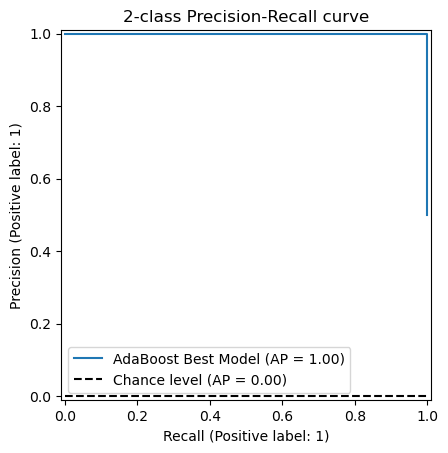


Evaluating AdaBoost Best Model Performance - val:
	Execution time: 0.534s
AdaBoost Best Model Performance - val:
	 Accuracy: 99.7433%
	 Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    134239
           1       1.00      1.00      1.00    248261

    accuracy                           1.00    382500
   macro avg       1.00      1.00      1.00    382500
weighted avg       1.00      1.00      1.00    382500



<Figure size 640x480 with 0 Axes>

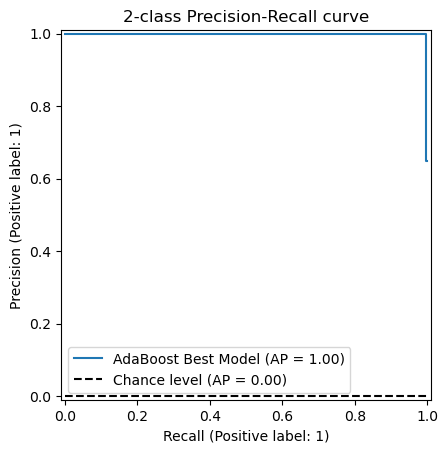


Evaluating AdaBoost Best Model Performance - test:
	Execution time: 0.685s
AdaBoost Best Model Performance - test:
	 Accuracy: 99.7247%
	 Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    158103
           1       1.00      1.00      1.00    291897

    accuracy                           1.00    450000
   macro avg       1.00      1.00      1.00    450000
weighted avg       1.00      1.00      1.00    450000



<Figure size 640x480 with 0 Axes>

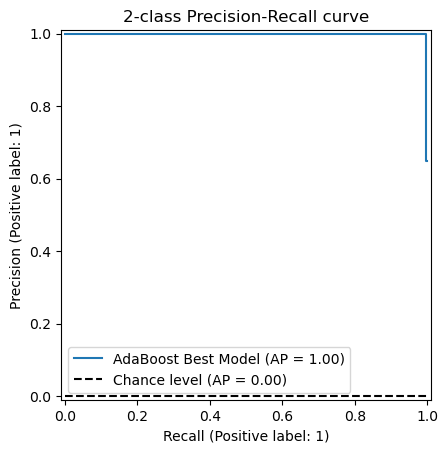

In [56]:
# Test the best model on the train, val and test datasets 
test_model("AdaBoost Best Model", "train", best_ada_model, X_train, y_train)
test_model("AdaBoost Best Model", "val", best_ada_model, X_val, y_val)
test_model("AdaBoost Best Model", "test", best_ada_model, X_test, y_test)


In [57]:
# Evaluate best AdaBoost model on random selections from full dataset

iter_tmr = SimpleTimer()
scores = []
times = []
iter_tmr.start()
for n in range(0,50):
    eval_df = full_df.sample(n=1000000)
    X_eval = eval_df.drop('target',axis=1)
    y_eval = eval_df[['target']]
    X_eval = preprocess(X_eval, silent=True)
    y_pred = best_ada_model.predict(X_eval)
    score = sklf1(y_eval, y_pred)
    scores.append(score)
    iter_time = iter_tmr.laptime()
    times.append(iter_time)
    print(f"Sample {n}: F1 Score {(score*1):.3%} ({iter_tmr.sts(iter_time)})")

tot_time = iter_tmr.stop()
print(f"Total time: {iter_tmr.sts(tot_time)}")
print(f"Mean F1 score: {np.mean(scores): .3%}")
print(f"Std Dev: {np.std(scores): .6f}")


Sample 0: F1 Score 99.799% (4.206s)
Sample 1: F1 Score 99.796% (4.097s)
Sample 2: F1 Score 99.795% (4.188s)
Sample 3: F1 Score 99.793% (4.083s)
Sample 4: F1 Score 99.798% (4.149s)
Sample 5: F1 Score 99.797% (4.022s)
Sample 6: F1 Score 99.796% (4.002s)
Sample 7: F1 Score 99.797% (4.058s)
Sample 8: F1 Score 99.798% (4.086s)
Sample 9: F1 Score 99.792% (4.042s)
Sample 10: F1 Score 99.791% (4.037s)
Sample 11: F1 Score 99.796% (4.095s)
Sample 12: F1 Score 99.793% (4.071s)
Sample 13: F1 Score 99.810% (3.994s)
Sample 14: F1 Score 99.793% (4.074s)
Sample 15: F1 Score 99.788% (4.127s)
Sample 16: F1 Score 99.795% (4.144s)
Sample 17: F1 Score 99.800% (3.960s)
Sample 18: F1 Score 99.794% (4.050s)
Sample 19: F1 Score 99.791% (4.129s)
Sample 20: F1 Score 99.792% (4.021s)
Sample 21: F1 Score 99.800% (3.995s)
Sample 22: F1 Score 99.797% (4.044s)
Sample 23: F1 Score 99.794% (4.119s)
Sample 24: F1 Score 99.804% (4.013s)
Sample 25: F1 Score 99.796% (4.077s)
Sample 26: F1 Score 99.799% (4.068s)
Sample 27: 

### Random Forest


In [58]:
rf_timer = SimpleTimer()

rf_model = RandomForestClassifier()

rf_param_grid = {
    # 'n_estimators': [ 100 + (n*20) for n in range(0,31)],
    'n_estimators': [ 8, 9, 10, 11, 12, 13, 14, 15],
    # 'max_depth': [n for n in range(2,16,2)],
    'max_depth': [n for n in range(2,6)],
    # 'min_samples_split': [n for n in range(2,7)],
    'min_samples_split': [2],
    'max_features': [0.5, 0.75, 0.9, 1.0],
    'max_samples': [0.5, 0.8, 1.0],
}

rf_random_search = RandomizedSearchCV(
    rf_model,
    rf_param_grid,
    scoring=f1SpeedScore,
    n_jobs=7,
    cv=5,
    n_iter=30,
    verbose=10,
    random_state=notebook_random_state
)

print(f"Started at {time.ctime()}")
rf_timer.start()
rf_random_search.fit(X_train, y_train["target"])
print(f"Time for random search: {rf_timer.sts(rf_timer.stop())}")
print(f"Finished at {time.ctime()}")


Started at Mon Feb 24 12:20:38 2025
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Time for random search: 6m 55.896s
Finished at Mon Feb 24 12:27:34 2025


In [59]:
display(rf_random_search.best_params_)
display(rf_random_search.best_score_)


{'n_estimators': 11,
 'min_samples_split': 2,
 'max_samples': 1.0,
 'max_features': 0.9,
 'max_depth': 5}

0.9983980523164918

In [60]:

display(pd.DataFrame(rf_random_search.cv_results_)[["mean_fit_time","mean_score_time","mean_test_score"]].sort_values(by="mean_test_score",ascending=False))

,mean_fit_time,mean_score_time,mean_test_score
2,25.931495,0.344205,0.998398
27,27.585499,0.333800,0.998392
3,26.648340,0.357131,0.998306
17,13.867650,0.289803,0.998211
5,28.106506,0.351002,0.998042
29,13.486857,0.202597,0.998005
18,24.871295,0.365398,0.997984
8,36.501537,0.407401,0.997882
9,28.232305,0.348405,0.996811
0,19.084077,0.328203,0.996576


In [61]:
display(pd.DataFrame(rf_random_search.cv_results_)
        [["mean_test_score","std_test_score","param_n_estimators","param_min_samples_split","param_max_samples","param_max_features","param_max_depth"]].sort_values(by="mean_test_score",ascending=False).head(10))

,mean_test_score,std_test_score,param_n_estimators,param_min_samples_split,param_max_samples,param_max_features,param_max_depth
2,0.998398,0.000379,11,2,1.0,0.90,5
27,0.998392,0.000296,12,2,1.0,0.90,5
3,0.998306,0.000840,12,2,1.0,0.75,5
17,0.998211,0.000097,8,2,0.5,1.00,5
5,0.998042,0.000141,12,2,0.8,1.00,5
29,0.998005,0.000434,12,2,0.8,0.50,5
18,0.997984,0.000069,15,2,0.5,1.00,5
8,0.997882,0.000118,15,2,0.8,1.00,5
9,0.996811,0.000424,14,2,1.0,0.75,4
0,0.996576,0.000058,12,2,0.5,1.00,4


In [62]:
best_rf_model = rf_random_search.best_estimator_


Evaluating Random Forest Best Model Performance - train:
	Execution time: 0.485s
Random Forest Best Model Performance - train:
	 Accuracy: 99.8775%
	 Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    760386
           1       1.00      1.00      1.00    757575

    accuracy                           1.00   1517961
   macro avg       1.00      1.00      1.00   1517961
weighted avg       1.00      1.00      1.00   1517961



<Figure size 640x480 with 0 Axes>

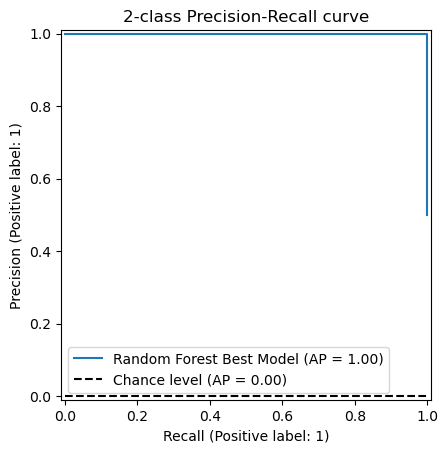


Evaluating Random Forest Best Model Performance - val:
	Execution time: 0.157s
Random Forest Best Model Performance - val:
	 Accuracy: 99.5982%
	 Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    134239
           1       1.00      0.99      1.00    248261

    accuracy                           1.00    382500
   macro avg       0.99      1.00      1.00    382500
weighted avg       1.00      1.00      1.00    382500



<Figure size 640x480 with 0 Axes>

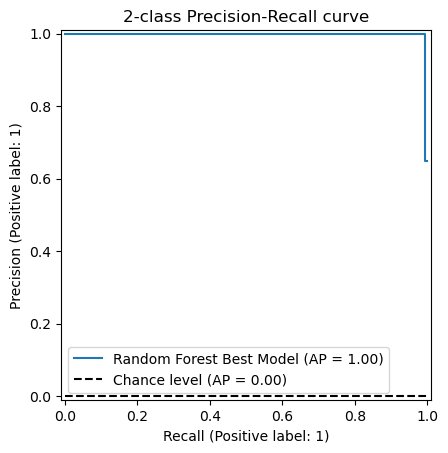


Evaluating Random Forest Best Model Performance - test:
	Execution time: 0.214s
Random Forest Best Model Performance - test:
	 Accuracy: 99.5771%
	 Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    158103
           1       1.00      0.99      1.00    291897

    accuracy                           1.00    450000
   macro avg       0.99      1.00      1.00    450000
weighted avg       1.00      1.00      1.00    450000



<Figure size 640x480 with 0 Axes>

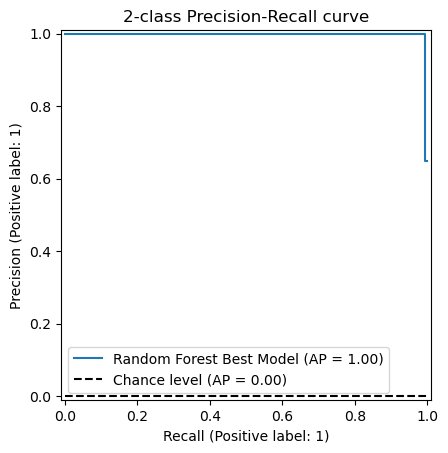

In [63]:
# Test the best model on the train, val and test datasets 
test_model("Random Forest Best Model", "train", best_rf_model, X_train, y_train)
test_model("Random Forest Best Model", "val", best_rf_model, X_val, y_val)
test_model("Random Forest Best Model", "test", best_rf_model, X_test, y_test)


In [64]:
# Evaluate best Random Forest model on random selections from full dataset

iter_tmr = SimpleTimer()
scores = []
times = []
iter_tmr.start()
for n in range(0,50):
    eval_df = full_df.sample(n=1000000)
    X_eval = eval_df.drop('target',axis=1)
    y_eval = eval_df[['target']]
    X_eval = preprocess(X_eval, silent=True)
    y_pred = best_rf_model.predict(X_eval)
    score = sklf1(y_eval, y_pred)
    scores.append(score)
    iter_time = iter_tmr.laptime()
    times.append(iter_time)
    print(f"Sample {n}: F1 Score {(score*1):.3%} ({iter_tmr.sts(iter_time)})")

tot_time = iter_tmr.stop()
print(f"Total time: {iter_tmr.sts(tot_time)}")
print(f"Mean F1 score: {np.mean(scores): .3%}")
print(f"Std Dev: {np.std(scores): .6f}")


Sample 0: F1 Score 99.676% (3.137s)
Sample 1: F1 Score 99.677% (2.984s)
Sample 2: F1 Score 99.679% (3.127s)
Sample 3: F1 Score 99.678% (3.142s)
Sample 4: F1 Score 99.673% (3.101s)
Sample 5: F1 Score 99.681% (3.021s)
Sample 6: F1 Score 99.679% (3.030s)
Sample 7: F1 Score 99.675% (3.067s)
Sample 8: F1 Score 99.683% (3.137s)
Sample 9: F1 Score 99.682% (3.088s)
Sample 10: F1 Score 99.675% (3.050s)
Sample 11: F1 Score 99.674% (3.053s)
Sample 12: F1 Score 99.673% (3.099s)
Sample 13: F1 Score 99.683% (3.102s)
Sample 14: F1 Score 99.678% (3.171s)
Sample 15: F1 Score 99.673% (3.041s)
Sample 16: F1 Score 99.672% (3.078s)
Sample 17: F1 Score 99.681% (3.015s)
Sample 18: F1 Score 99.684% (3.079s)
Sample 19: F1 Score 99.683% (3.166s)
Sample 20: F1 Score 99.672% (3.020s)
Sample 21: F1 Score 99.682% (2.971s)
Sample 22: F1 Score 99.678% (3.219s)
Sample 23: F1 Score 99.677% (3.148s)
Sample 24: F1 Score 99.672% (3.173s)
Sample 25: F1 Score 99.681% (3.124s)
Sample 26: F1 Score 99.675% (3.157s)
Sample 27: 

### Gradient Boosting


In [68]:
gb_timer = SimpleTimer()

gb_model = GradientBoostingClassifier()

gb_param_grid = {
    # 'n_estimators': [10 + (n*10) for n in range(0,20)],
    'n_estimators': [8, 9, 10, 11, 12],
    # 'learning_rate': [0 + (n*0.2) for n in range(1,8)],
    'learning_rate': [0 + (n*0.1) for n in range(1,11)],
    # 'min_samples_split': [n for n in range(2,9)],
    'min_samples_split': [2],
    # 'max_depth': [n for n in range(2,16)]
    'max_depth': [4, 5]
}

gb_random_search = RandomizedSearchCV(
    gb_model,
    gb_param_grid,
    scoring=f1SpeedScore,
    n_jobs=7,
    cv=5,
    n_iter=30,
    verbose=10,
    random_state=notebook_random_state
)

print(f"Started at {time.ctime()}")
gb_timer.start()
gb_random_search.fit(X_train, y_train["target"])
print(f"Time for random search: {gb_timer.sts(gb_timer.stop())}")
print(f"Finished at {time.ctime()}")


Started at Mon Feb 24 12:36:53 2025
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Time for random search: 14m 27.940s
Finished at Mon Feb 24 12:51:21 2025


In [69]:
display(gb_random_search.best_params_)
display(gb_random_search.best_score_)


{'n_estimators': 9,
 'min_samples_split': 2,
 'max_depth': 5,
 'learning_rate': 0.8}

0.9991599978865912

In [70]:
display(pd.DataFrame(gb_random_search.cv_results_)[["mean_fit_time","mean_score_time","mean_test_score"]].sort_values(by="mean_test_score",ascending=False))

,mean_fit_time,mean_score_time,mean_test_score
16,39.514539,0.377808,0.999160
29,31.877932,0.263792,0.999097
24,53.739400,0.391404,0.999095
17,46.144776,0.405183,0.999073
27,40.535947,0.413603,0.999070
20,33.167651,0.360611,0.999028
14,31.068510,0.359810,0.998990
7,30.813711,0.361607,0.998949
21,52.209592,0.449402,0.998939
0,44.989967,0.411003,0.998904


In [71]:
display(pd.DataFrame(gb_random_search.cv_results_)
        [["mean_test_score","std_test_score","param_n_estimators","param_min_samples_split","param_max_depth","param_learning_rate"]].sort_values(by="mean_test_score",ascending=False).head(10))

,mean_test_score,std_test_score,param_n_estimators,param_min_samples_split,param_max_depth,param_learning_rate
16,0.999160,0.000041,9,2,5,0.8
29,0.999097,0.000254,10,2,4,0.8
24,0.999095,0.000076,12,2,5,0.7
17,0.999073,0.000050,10,2,5,0.8
27,0.999070,0.000064,9,2,5,1.0
20,0.999028,0.000051,8,2,5,0.6
14,0.998990,0.000059,8,2,4,1.0
7,0.998949,0.000132,8,2,4,0.9
21,0.998939,0.000117,11,2,5,0.9
0,0.998904,0.000185,11,2,4,0.9


In [72]:
best_gb_model = gb_random_search.best_estimator_


Evaluating GB Best Model Performance - train:
	Execution time: 0.464s
GB Best Model Performance - train:
	 Accuracy: 99.9979%
	 Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    760386
           1       1.00      1.00      1.00    757575

    accuracy                           1.00   1517961
   macro avg       1.00      1.00      1.00   1517961
weighted avg       1.00      1.00      1.00   1517961



<Figure size 640x480 with 0 Axes>

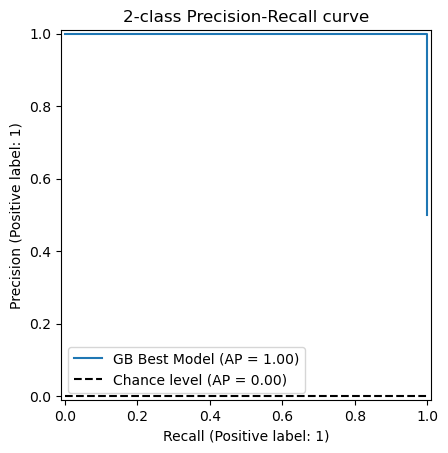


Evaluating GB Best Model Performance - val:
	Execution time: 0.127s
GB Best Model Performance - val:
	 Accuracy: 99.7412%
	 Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    134239
           1       1.00      1.00      1.00    248261

    accuracy                           1.00    382500
   macro avg       1.00      1.00      1.00    382500
weighted avg       1.00      1.00      1.00    382500



<Figure size 640x480 with 0 Axes>

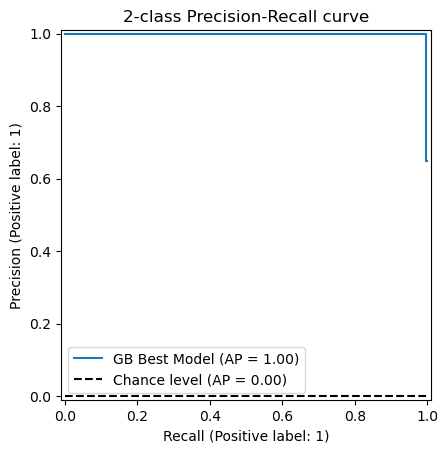


Evaluating GB Best Model Performance - test:
	Execution time: 0.192s
GB Best Model Performance - test:
	 Accuracy: 99.7233%
	 Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    158103
           1       1.00      1.00      1.00    291897

    accuracy                           1.00    450000
   macro avg       1.00      1.00      1.00    450000
weighted avg       1.00      1.00      1.00    450000



<Figure size 640x480 with 0 Axes>

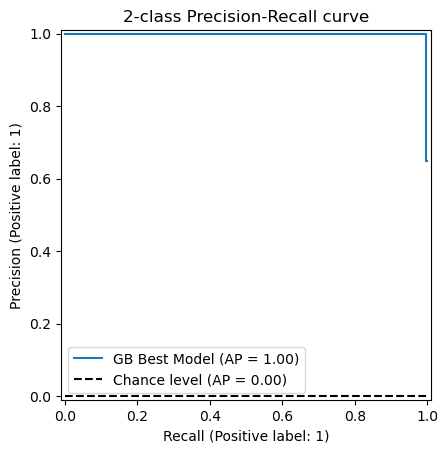

In [73]:
# Test the best model on the train, val and test datasets 
test_model("GB Best Model", "train", best_gb_model, X_train, y_train)
test_model("GB Best Model", "val", best_gb_model, X_val, y_val)
test_model("GB Best Model", "test", best_gb_model, X_test, y_test)



In [74]:
# Evaluate best Gradient Boosting model on random selections from full dataset

iter_tmr = SimpleTimer()
scores = []
times = []
iter_tmr.start()
for n in range(0,50):
    eval_df = full_df.sample(n=1000000)
    X_eval = eval_df.drop('target',axis=1)
    y_eval = eval_df[['target']]
    X_eval = preprocess(X_eval, silent=True)
    y_pred = best_gb_model.predict(X_eval)
    score = sklf1(y_eval, y_pred)
    scores.append(score)
    iter_time = iter_tmr.laptime()
    times.append(iter_time)
    print(f"Sample {n}: F1 Score {(score*1):.3%} ({iter_tmr.sts(iter_time)})")

tot_time = iter_tmr.stop()
print(f"Total time: {iter_tmr.sts(tot_time)}")
print(f"Mean F1 score: {np.mean(scores): .3%}")
print(f"Std Dev: {np.std(scores): .6f}")


Sample 0: F1 Score 99.798% (3.471s)
Sample 1: F1 Score 99.794% (3.004s)
Sample 2: F1 Score 99.789% (3.069s)
Sample 3: F1 Score 99.794% (3.009s)
Sample 4: F1 Score 99.790% (3.008s)
Sample 5: F1 Score 99.795% (3.086s)
Sample 6: F1 Score 99.797% (3.071s)
Sample 7: F1 Score 99.794% (3.037s)
Sample 8: F1 Score 99.796% (2.980s)
Sample 9: F1 Score 99.792% (3.048s)
Sample 10: F1 Score 99.790% (3.017s)
Sample 11: F1 Score 99.787% (3.238s)
Sample 12: F1 Score 99.795% (3.012s)
Sample 13: F1 Score 99.796% (2.971s)
Sample 14: F1 Score 99.797% (3.041s)
Sample 15: F1 Score 99.796% (3.053s)
Sample 16: F1 Score 99.791% (3.184s)
Sample 17: F1 Score 99.794% (2.984s)
Sample 18: F1 Score 99.796% (3.035s)
Sample 19: F1 Score 99.788% (3.069s)
Sample 20: F1 Score 99.795% (3.006s)
Sample 21: F1 Score 99.793% (3.093s)
Sample 22: F1 Score 99.791% (3.016s)
Sample 23: F1 Score 99.790% (3.021s)
Sample 24: F1 Score 99.802% (3.026s)
Sample 25: F1 Score 99.792% (3.001s)
Sample 26: F1 Score 99.794% (3.058s)
Sample 27: 

### Tweak Gradient Boost
Since best model from the random search on Gradient Boost did not even 
perform as well as the default parameters from earlier, I'm going to try a narrowed grid search
to see if I can out-perform the best model from the AdaBoost random search.

In [85]:
gb2_timer = SimpleTimer()

gb2_model = GradientBoostingClassifier()

gb2_param_grid = {
    'n_estimators': [9, 10, 11],
    'learning_rate': [0.2, 0.5, 0.75, 1.0],
    'min_samples_split': [2],
    'max_depth': [4]
}

gb_grid_search = GridSearchCV(
    gb2_model,
    gb2_param_grid,
    scoring=f1SpeedScore,
    n_jobs=7,
    cv=5,
    verbose=10,
)

print(f"Started at {time.ctime()}")
gb2_timer.start()
gb_grid_search.fit(X_train, y_train["target"])
print(f"Time for grid search: {gb2_timer.sts(gb2_timer.stop())}")
print(f"Finished at {time.ctime()}")


Started at Mon Feb 24 13:48:37 2025
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Time for grid search: 6m 7.133s
Finished at Mon Feb 24 13:54:44 2025


In [86]:
display(gb_grid_search.best_params_)
display(gb_grid_search.best_score_)


{'learning_rate': 1.0,
 'max_depth': 4,
 'min_samples_split': 2,
 'n_estimators': 11}

0.9993359398826632

In [87]:
display(pd.DataFrame(gb_grid_search.cv_results_)
        [["mean_test_score","std_test_score","param_n_estimators","param_min_samples_split","param_max_depth","param_learning_rate"]].sort_values(by="mean_test_score",ascending=False))

,mean_test_score,std_test_score,param_n_estimators,param_min_samples_split,param_max_depth,param_learning_rate
11,0.999336,0.000112,11,2,4,1.00
7,0.998964,0.000103,10,2,4,0.75
10,0.998953,0.000102,10,2,4,1.00
9,0.998870,0.000064,9,2,4,1.00
8,0.998849,0.000162,11,2,4,0.75
6,0.998823,0.000063,9,2,4,0.75
4,0.998746,0.000089,10,2,4,0.50
3,0.998682,0.000080,9,2,4,0.50
5,0.998599,0.000078,11,2,4,0.50
0,0.996583,0.000097,9,2,4,0.20


In [88]:
best_gb2_model = gb_grid_search.best_estimator_


In [89]:
# Evaluate best Gradient Boosting model on random selections from full dataset

iter_tmr = SimpleTimer()
scores = []
times = []
iter_tmr.start()
for n in range(0,50):
    eval_df = full_df.sample(n=1000000)
    X_eval = eval_df.drop('target',axis=1)
    y_eval = eval_df[['target']]
    X_eval = preprocess(X_eval, silent=True)
    y_pred = best_gb2_model.predict(X_eval)
    score = sklf1(y_eval, y_pred)
    scores.append(score)
    iter_time = iter_tmr.laptime()
    times.append(iter_time)
    print(f"Sample {n}: F1 Score {(score*1):.3%} ({iter_tmr.sts(iter_time)})")

tot_time = iter_tmr.stop()
print(f"Total time: {iter_tmr.sts(tot_time)}")
print(f"Mean F1 score: {np.mean(scores): .3%}")
print(f"Std Dev: {np.std(scores): .6f}")


Sample 0: F1 Score 99.969% (3.519s)
Sample 1: F1 Score 99.969% (3.272s)
Sample 2: F1 Score 99.968% (3.136s)
Sample 3: F1 Score 99.971% (3.156s)
Sample 4: F1 Score 99.969% (3.116s)
Sample 5: F1 Score 99.973% (3.081s)
Sample 6: F1 Score 99.971% (3.142s)
Sample 7: F1 Score 99.969% (3.112s)
Sample 8: F1 Score 99.972% (3.222s)
Sample 9: F1 Score 99.973% (3.138s)
Sample 10: F1 Score 99.970% (3.072s)
Sample 11: F1 Score 99.969% (3.113s)
Sample 12: F1 Score 99.968% (3.088s)
Sample 13: F1 Score 99.969% (3.186s)
Sample 14: F1 Score 99.968% (3.174s)
Sample 15: F1 Score 99.968% (3.116s)
Sample 16: F1 Score 99.968% (3.120s)
Sample 17: F1 Score 99.970% (3.093s)
Sample 18: F1 Score 99.971% (3.206s)
Sample 19: F1 Score 99.967% (3.057s)
Sample 20: F1 Score 99.967% (3.078s)
Sample 21: F1 Score 99.972% (3.154s)
Sample 22: F1 Score 99.971% (3.117s)
Sample 23: F1 Score 99.972% (3.215s)
Sample 24: F1 Score 99.971% (3.085s)
Sample 25: F1 Score 99.971% (3.078s)
Sample 26: F1 Score 99.970% (3.073s)
Sample 27: 

In [90]:
# Manual tweaking to avoid overfitting
best_gb2_model = GradientBoostingClassifier(n_estimators=10, learning_rate=1.0, max_depth=4)
best_gb2_model.fit(X_train,y_train["target"])


GradientBoostingClassifier(learning_rate=1.0, max_depth=4, n_estimators=10)

In [91]:
# Evaluate best Gradient Boosting model on random selections from full dataset

iter_tmr = SimpleTimer()
scores = []
times = []
iter_tmr.start()
for n in range(0,50):
    eval_df = full_df.sample(n=1000000)
    X_eval = eval_df.drop('target',axis=1)
    y_eval = eval_df[['target']]
    X_eval = preprocess(X_eval, silent=True)
    y_pred = best_gb2_model.predict(X_eval)
    score = sklf1(y_eval, y_pred)
    scores.append(score)
    iter_time = iter_tmr.laptime()
    times.append(iter_time)
    print(f"Sample {n}: F1 Score {(score*1):.3%} ({iter_tmr.sts(iter_time)})")

tot_time = iter_tmr.stop()
print(f"Total time: {iter_tmr.sts(tot_time)}")
print(f"Mean F1 score: {np.mean(scores): .3%}")
print(f"Std Dev: {np.std(scores): .6f}")


Sample 0: F1 Score 99.971% (3.416s)
Sample 1: F1 Score 99.971% (3.208s)
Sample 2: F1 Score 99.971% (3.115s)
Sample 3: F1 Score 99.971% (3.208s)
Sample 4: F1 Score 99.971% (3.130s)
Sample 5: F1 Score 99.971% (3.109s)
Sample 6: F1 Score 99.971% (3.066s)
Sample 7: F1 Score 99.969% (3.077s)
Sample 8: F1 Score 99.968% (3.232s)
Sample 9: F1 Score 99.972% (3.126s)
Sample 10: F1 Score 99.970% (3.114s)
Sample 11: F1 Score 99.971% (3.080s)
Sample 12: F1 Score 99.973% (3.057s)
Sample 13: F1 Score 99.970% (3.164s)
Sample 14: F1 Score 99.968% (3.069s)
Sample 15: F1 Score 99.970% (3.099s)
Sample 16: F1 Score 99.973% (3.164s)
Sample 17: F1 Score 99.967% (3.181s)
Sample 18: F1 Score 99.974% (3.215s)
Sample 19: F1 Score 99.971% (3.104s)
Sample 20: F1 Score 99.968% (3.069s)
Sample 21: F1 Score 99.972% (3.063s)
Sample 22: F1 Score 99.969% (3.092s)
Sample 23: F1 Score 99.969% (3.172s)
Sample 24: F1 Score 99.970% (3.168s)
Sample 25: F1 Score 99.971% (3.068s)
Sample 26: F1 Score 99.968% (3.090s)
Sample 27: 

**That's looking good. Now, for fairness, let's try tweaking AdaBoost**

In [81]:
ada2_timer = SimpleTimer()

ada2_base_classifier = DecisionTreeClassifier(max_depth=4)
ada2_model = AdaBoostClassifier(estimator=ada2_base_classifier, algorithm='SAMME')

ada2_param_grid = {
    'n_estimators': [9, 10, 11],
    'learning_rate': [0.2, 0.5, 0.75, 1.0],
}

ada_grid_search = GridSearchCV(
    ada2_model,
    ada2_param_grid,
    scoring=f1SpeedScore,
    n_jobs=7,
    cv=5,
    verbose=10,
)

print(f"Started at {time.ctime()}")
ada2_timer.start()
ada_grid_search.fit(X_train, y_train["target"])
print(f"Time for grid search: {ada2_timer.sts(ada2_timer.stop())}")
print(f"Finished at {time.ctime()}")


Started at Mon Feb 24 13:39:57 2025
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Time for grid search: 6m 27.961s
Finished at Mon Feb 24 13:46:25 2025


In [82]:
display(ada_grid_search.best_params_)
display(ada_grid_search.best_score_)


{'learning_rate': 1.0, 'n_estimators': 11}

0.9984629956002335

In [83]:
display(pd.DataFrame(ada_grid_search.cv_results_)
        [["mean_test_score","std_test_score","param_n_estimators","param_learning_rate"]].sort_values(by="mean_test_score",ascending=False))

,mean_test_score,std_test_score,param_n_estimators,param_learning_rate
11,0.998463,0.000241,11,1.00
9,0.997506,0.000071,9,1.00
6,0.997439,0.000173,9,0.75
10,0.997433,0.000111,10,1.00
0,0.997220,0.000047,9,0.20
3,0.997130,0.000118,9,0.50
7,0.997104,0.000238,10,0.75
8,0.996996,0.000172,11,0.75
4,0.996870,0.000195,10,0.50
1,0.996819,0.000143,10,0.20


In [92]:
best_ada2_model = ada_grid_search.best_estimator_


In [93]:
# Evaluate best AdaBoost model on random selections from full dataset

iter_tmr = SimpleTimer()
scores = []
times = []
iter_tmr.start()
for n in range(0,50):
    eval_df = full_df.sample(n=1000000)
    X_eval = eval_df.drop('target',axis=1)
    y_eval = eval_df[['target']]
    X_eval = preprocess(X_eval, silent=True)
    y_pred = best_ada2_model.predict(X_eval)
    score = sklf1(y_eval, y_pred)
    scores.append(score)
    iter_time = iter_tmr.laptime()
    times.append(iter_time)
    print(f"Sample {n}: F1 Score {(score*1):.3%} ({iter_tmr.sts(iter_time)})")

tot_time = iter_tmr.stop()
print(f"Total time: {iter_tmr.sts(tot_time)}")
print(f"Mean F1 score: {np.mean(scores): .3%}")
print(f"Std Dev: {np.std(scores): .6f}")


Sample 0: F1 Score 99.778% (3.713s)
Sample 1: F1 Score 99.777% (4.089s)
Sample 2: F1 Score 99.773% (4.004s)
Sample 3: F1 Score 99.780% (3.885s)
Sample 4: F1 Score 99.776% (3.845s)
Sample 5: F1 Score 99.774% (4.009s)
Sample 6: F1 Score 99.768% (3.853s)
Sample 7: F1 Score 99.777% (3.889s)
Sample 8: F1 Score 99.774% (3.820s)
Sample 9: F1 Score 99.778% (3.944s)
Sample 10: F1 Score 99.781% (3.829s)
Sample 11: F1 Score 99.778% (3.820s)
Sample 12: F1 Score 99.779% (3.829s)
Sample 13: F1 Score 99.774% (3.938s)
Sample 14: F1 Score 99.790% (3.841s)
Sample 15: F1 Score 99.783% (3.867s)
Sample 16: F1 Score 99.775% (3.814s)
Sample 17: F1 Score 99.781% (4.016s)
Sample 18: F1 Score 99.769% (3.872s)
Sample 19: F1 Score 99.781% (3.832s)
Sample 20: F1 Score 99.780% (3.801s)
Sample 21: F1 Score 99.779% (3.955s)
Sample 22: F1 Score 99.777% (3.875s)
Sample 23: F1 Score 99.775% (3.815s)
Sample 24: F1 Score 99.795% (3.789s)
Sample 25: F1 Score 99.777% (3.860s)
Sample 26: F1 Score 99.775% (3.965s)
Sample 27: 

In [95]:
# Manual tweaking to avoid overfitting
ada2_base_classifier = DecisionTreeClassifier(max_depth=5)
best_ada2_model = AdaBoostClassifier(n_estimators=10, learning_rate=0.25, estimator=ada2_base_classifier, algorithm='SAMME')
best_ada2_model.fit(X_train,y_train["target"])


AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=5),
                   learning_rate=0.25, n_estimators=10)

In [96]:
# Evaluate best AdaBoostg model on random selections from full dataset

iter_tmr = SimpleTimer()
scores = []
times = []
iter_tmr.start()
for n in range(0,50):
    eval_df = full_df.sample(n=1000000)
    X_eval = eval_df.drop('target',axis=1)
    y_eval = eval_df[['target']]
    X_eval = preprocess(X_eval, silent=True)
    y_pred = best_ada2_model.predict(X_eval)
    score = sklf1(y_eval, y_pred)
    scores.append(score)
    iter_time = iter_tmr.laptime()
    times.append(iter_time)
    print(f"Sample {n}: F1 Score {(score*1):.3%} ({iter_tmr.sts(iter_time)})")

tot_time = iter_tmr.stop()
print(f"Total time: {iter_tmr.sts(tot_time)}")
print(f"Mean F1 score: {np.mean(scores): .3%}")
print(f"Std Dev: {np.std(scores): .6f}")


Sample 0: F1 Score 99.971% (4.064s)
Sample 1: F1 Score 99.972% (3.869s)
Sample 2: F1 Score 99.972% (3.742s)
Sample 3: F1 Score 99.971% (3.782s)
Sample 4: F1 Score 99.969% (3.801s)
Sample 5: F1 Score 99.971% (3.866s)
Sample 6: F1 Score 99.971% (3.753s)
Sample 7: F1 Score 99.973% (3.757s)
Sample 8: F1 Score 99.971% (3.802s)
Sample 9: F1 Score 99.970% (3.941s)
Sample 10: F1 Score 99.970% (3.704s)
Sample 11: F1 Score 99.973% (3.772s)
Sample 12: F1 Score 99.972% (3.850s)
Sample 13: F1 Score 99.971% (3.841s)
Sample 14: F1 Score 99.970% (3.765s)
Sample 15: F1 Score 99.972% (3.732s)
Sample 16: F1 Score 99.970% (3.814s)
Sample 17: F1 Score 99.971% (3.853s)
Sample 18: F1 Score 99.969% (4.030s)
Sample 19: F1 Score 99.969% (3.933s)
Sample 20: F1 Score 99.970% (3.961s)
Sample 21: F1 Score 99.971% (3.834s)
Sample 22: F1 Score 99.971% (3.797s)
Sample 23: F1 Score 99.969% (3.768s)
Sample 24: F1 Score 99.969% (3.758s)
Sample 25: F1 Score 99.972% (3.815s)
Sample 26: F1 Score 99.970% (3.846s)
Sample 27: 

---
# Conclusion

AdaBoost and Gradient Boost have similar performance, but Gradient Boost runs ~30% faster. Based on performance shown on random samples of 1M records each from the whole dataset, both models generalize well.

So, due to it's faster performance, for this project I will use a Gradient Boost model with learning_rate=1.0, max_depth=4, and n_estimators=10.